# 摘要

# 理论模型

ETF 与成份证券的无风险套利可能机会不多并且操作繁琐。\cite{Chan:2013} 给出了一个基于统计套利的策略：
1. 用过去一段时间的数据对 ETF 及其成份证券进行协整检验，筛选 p 值小于某个阈值的股票作为对冲标的；
2. 将 1 中筛选出来的股票加权形成投资组合，权重可以是等权，或某种优化算法；
3. 检验 2 中形成的投资组合与 ETF 的协整性，如果满足协整，则可以用于构造传统的均值回归策略；

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()
HDB = QS.FactorDB.HDF5DB()

In [9]:
# 参数设置和数据准备
ETFID = '510050.SH'# ETF ID, 比如, 50ETF, 510050.SH; 深 100ETF, 159901.SZ

StartDT = dt.datetime(2010, 1, 1)# 回测开始时点
EndDT = dt.datetime(2017, 12, 31)# 回测结束时点

WDB.connect()
FT = WDB.getTable("中国封闭式基金日行情")
DTs = FT.getDateTime(ifactor_name="复权收盘价(元)", iid=ETFID, start_dt=StartDT, end_dt=EndDT)
ETFPrice = FT.readData(factor_names=["复权收盘价(元)"], ids=[ETFID], dts=DTs).iloc[0, :, 0]
FT = WDB.getTable("中国ETF申购赎回成份")
StockIDs = FT.getID(ifactor_name="股票数量")
PCFCon = FT.readData(factor_names=["股票数量"], ids=StockIDs, dts=DTs, args={"基金Wind代码":"510050.SH"}).iloc[0]
WDB.disconnect()

HDB.connect()
FT = HDB.getTable("ElementaryFactor")
StockPrice = FT.readData(factor_names=["复权收盘价"], ids=StockIDs, dts=DTs).iloc[0];


----------- ETF - Stock Portfolio Cointegration ADF Test -----------
Statistic: -3.362289
pvalue : 0.046715
----------- ETF - Stock Portfolio Cointegration Johansen Test: r<=%d -----------
Trace Statistic: 15.387558
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 14.178632
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- ETF - Stock Portfolio Cointegration Johansen Test: r<=%d -----------
Trace Statistic: 1.208926
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 1.208926
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.         -0.06065713]


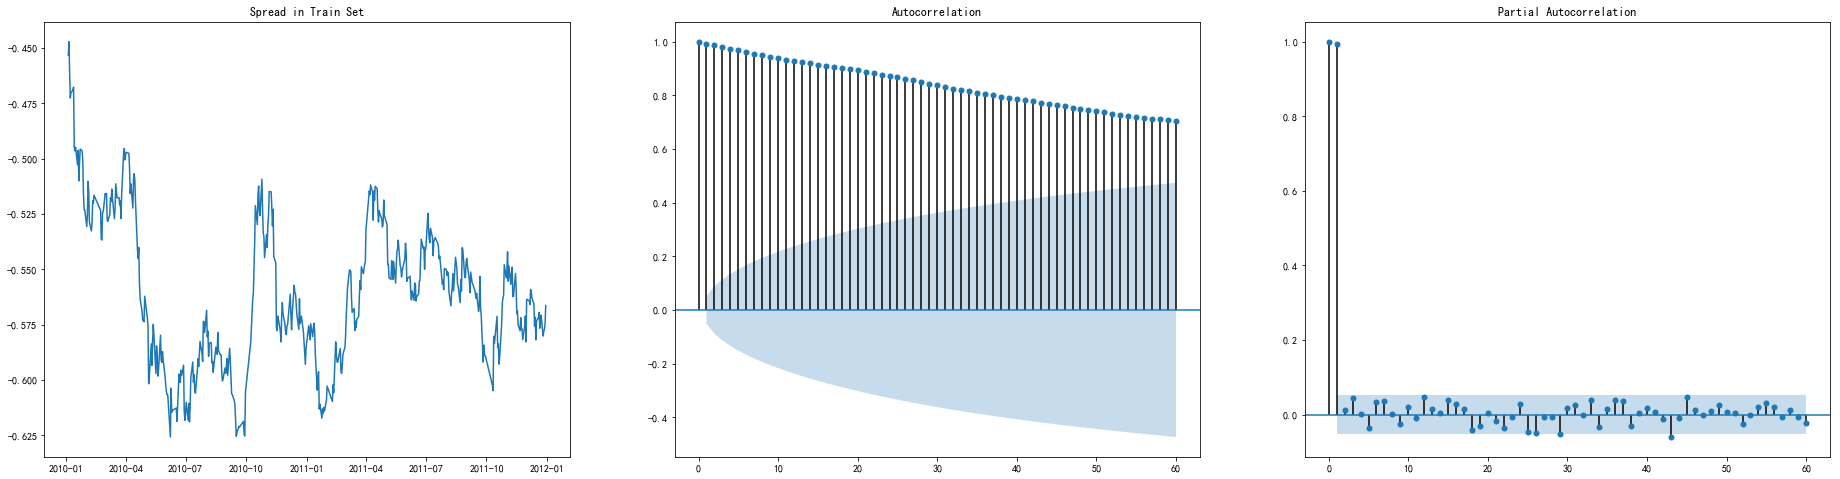

In [17]:
# 在训练集中检测协整性并选股形成投资组合
TrainStartDT = StartDT# 训练集的起始时点
TrainEndDT = dt.datetime(2011, 12, 31)# 训练集的结束时点
MinSampleLen = 240# 最小的样本长度
pValueThreshold = 0.1# p 值阈值

TrainStkPrice = StockPrice.loc[TrainStartDT:TrainEndDT]
TrainETFPrice = ETFPrice.loc[TrainStartDT:TrainEndDT]
TargetStkIDs = PCFCon.loc[TrainStartDT:TrainEndDT].iloc[-1]
TargetStkIDs = TargetStkIDs[TargetStkIDs>0].index.tolist()
pValue = pd.Series(np.nan, index=TargetStkIDs)
for i, iID in enumerate(tqdm_notebook(TargetStkIDs)):
    iX = np.c_[TrainETFPrice.values, TrainStkPrice.loc[:, iID].values]
    iX = iX[np.all(pd.notnull(iX), axis=1), :]
    if iX.shape[0]<MinSampleLen: continue
    iCointEGTest = sm.tsa.stattools.coint(iX[:, 0], iX[:, 1], trend="c", autolag="BIC")
    pValue.iloc[i] = iCointEGTest[1]

TargetStkIDs = pValue[pValue<=pValueThreshold].index.tolist()
StkPortLogVal = np.log(TrainStkPrice.loc[:, TargetStkIDs]).sum(axis=1)# 等权组合
iCointEGTest = sm.tsa.stattools.coint(np.log(TrainETFPrice.values), StkPortLogVal, trend="c", autolag="BIC")
print("----------- ETF - Stock Portfolio Cointegration ADF Test -----------",
      ("Statistic: %f" % iCointEGTest[0]), 
      ("pvalue : %f" % iCointEGTest[1]), sep="\n")
CointJohansenTest = sm.tsa.var.vecm.coint_johansen(np.c_[np.log(TrainETFPrice.values), StkPortLogVal], det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print("----------- ETF - Stock Portfolio Cointegration Johansen Test: r<=%d -----------",
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

TrainSpread = pd.Series(np.nansum(np.c_[np.log(TrainETFPrice.values), StkPortLogVal] * HedgeRatio, axis=1), index=TrainETFPrice.index)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(TrainSpread)
Axes[0].set_title("Spread in Train Set")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

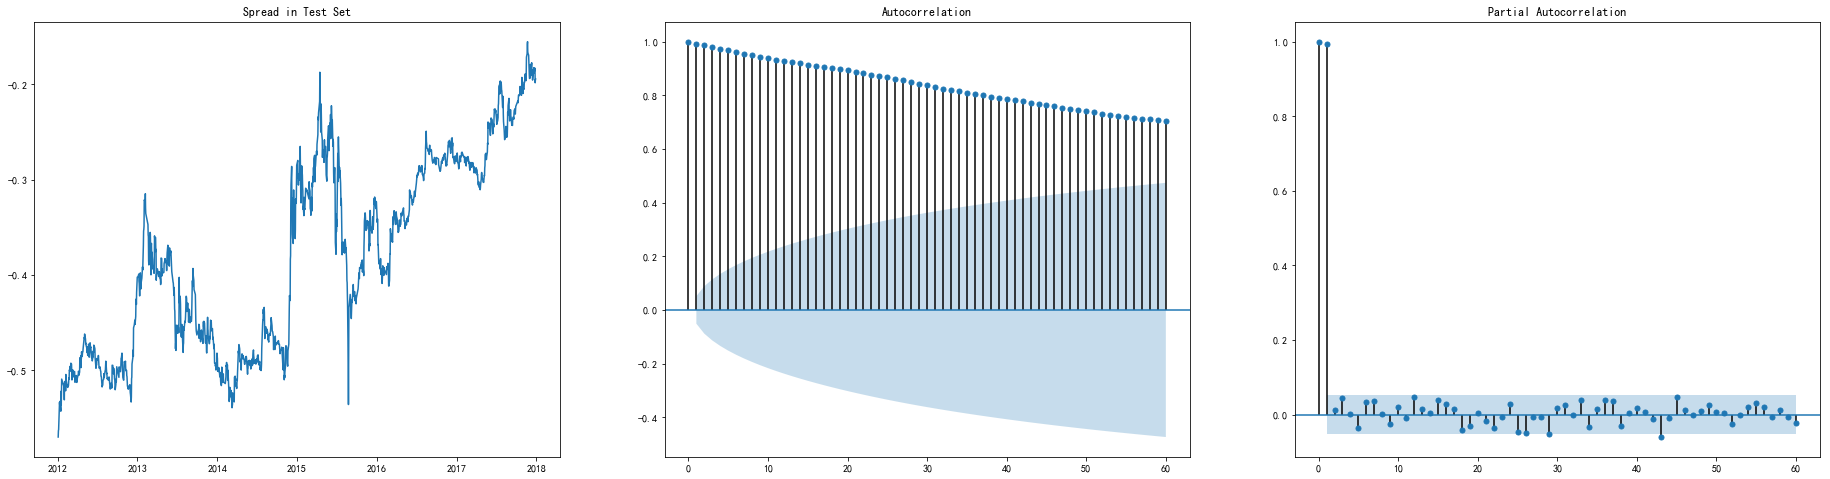

In [18]:
# 在测试集中计算 Spread
TestStartDT = dt.datetime(2012, 1, 1)# 测试集的起始时点
TestEndDT = EndDT# 测试集的结束时点

TestStkPrice = StockPrice.loc[TestStartDT:TestEndDT, TargetStkIDs]
TestETFPrice = ETFPrice.loc[TestStartDT:TestEndDT]
TestSpread = pd.Series(np.nansum(np.c_[np.log(TestETFPrice.values), np.log(TestStkPrice).sum(axis=1).values] * HedgeRatio, axis=1), index=TestStkPrice.index)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(TestSpread)
Axes[0].set_title("Spread in Test Set")
sm.graphics.tsa.plot_acf(TestSpread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(TestSpread, lags=60, ax=Axes[2]);

HalfLife: 16.763347


,0
起始时点,2012-01-04 00:00:00
结束时点,2017-12-29 00:00:00
时点数,1458
总收益率,0.275921
年化收益率,0.0415247
年化波动率,0.102423
Sharpe比率,0.405424
胜率,0.539781
最大回撤率,0.173177
最大回撤开始时点,2015-03-13 00:00:00


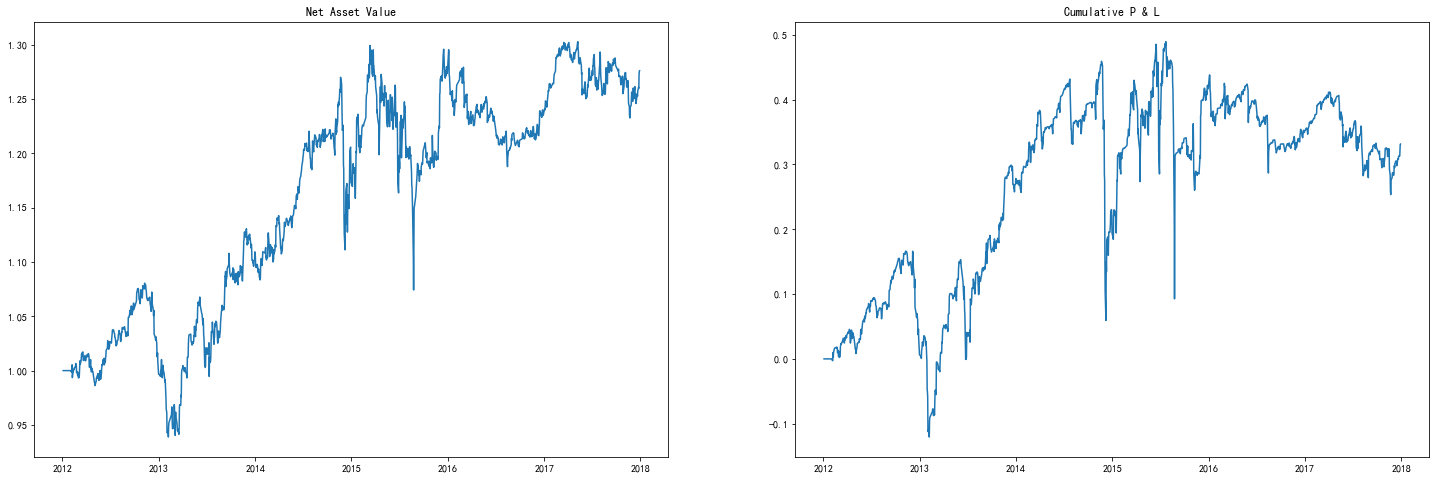

In [22]:
# --------线性均值回归策略--------
# 估计均值回复的半衰期
HalfLife = - np.log(2) / sm.OLS(np.diff(TrainSpread.values), sm.add_constant(TrainSpread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)

LookBack = max(5, int(round(HalfLife)))
Zscore = (TestSpread - TestSpread.rolling(LookBack).mean()) / TestSpread.rolling(LookBack).cov()**0.5
Amount = np.c_[- Zscore.values * HedgeRatio[0], np.repeat(- Zscore.values.reshape((Zscore.shape[0], 1)), TestStkPrice.shape[1], axis=1) * HedgeRatio[1]]
Amount[pd.isnull(Amount)] = 0
TestPrice = np.c_[TestETFPrice.values, TestStkPrice.values]
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(Amount / TestPrice, TestPrice)
Return, PNL = pd.Series(Return, index=TestStkPrice.index), pd.DataFrame(PNL, index=TestStkPrice.index, columns=[ETFID]+TestStkPrice.columns.tolist())
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

HalfLife: 16.763347


,0
起始时点,2012-01-04 00:00:00
结束时点,2017-12-29 00:00:00
时点数,1458
总收益率,0.157107
年化收益率,0.0246643
年化波动率,0.0800205
Sharpe比率,0.308224
胜率,0.76749
最大回撤率,0.123209
最大回撤开始时点,2015-06-16 00:00:00


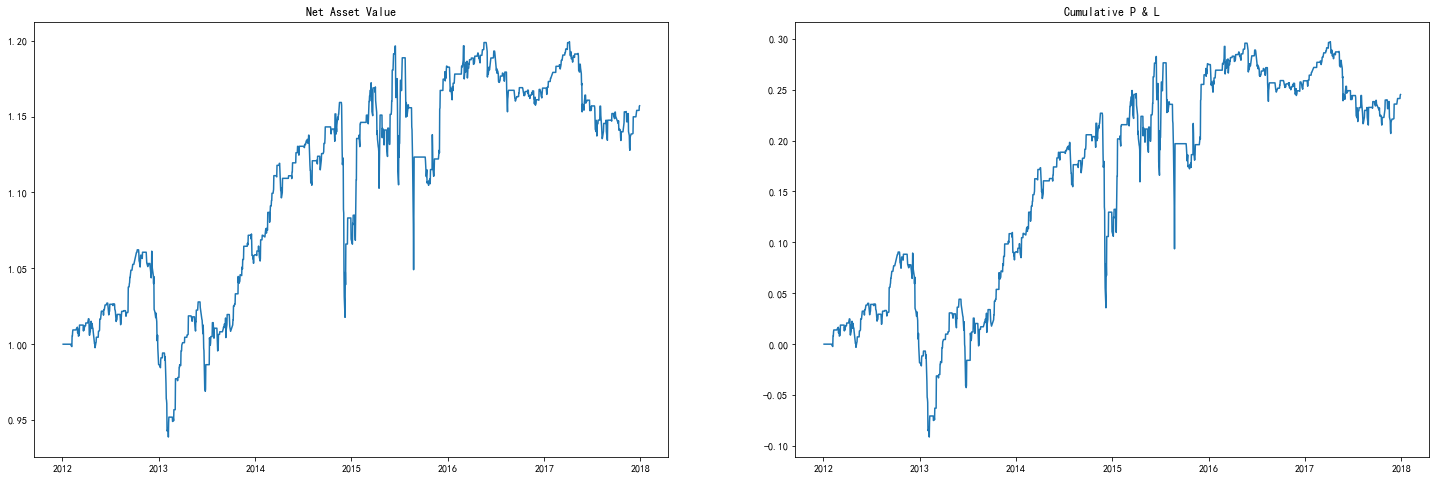

In [23]:
# --------基于 Bolling Band 的均值回归策略--------
EntryThreshold, ExitThreshold = 1, 0

# 估计均值回复的半衰期
HalfLife = - np.log(2) / sm.OLS(np.diff(TrainSpread.values), sm.add_constant(TrainSpread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)

LookBack = max(5, int(round(HalfLife)))
Zscore = (TestSpread - TestSpread.rolling(LookBack).mean()) / TestSpread.rolling(LookBack).cov()**0.5
Amount = np.zeros(Zscore.shape[0])
Mask = (Zscore.values>EntryThreshold)
Amount[Mask] = -1
Mask = (Zscore.values<-EntryThreshold)
Amount[Mask] = 1
Mask = (np.abs(Zscore.values)<=ExitThreshold)
Amount[Mask] = 0
Amount = np.c_[Amount * HedgeRatio[0], np.repeat(Amount.reshape((Amount.shape[0], 1)), TestStkPrice.shape[1], axis=1) * HedgeRatio[1]]
Amount[pd.isnull(Amount)] = 0
TestPrice = np.c_[TestETFPrice.values, TestStkPrice.values]
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(Amount / TestPrice, TestPrice)
Return, PNL = pd.Series(Return, index=TestStkPrice.index), pd.DataFrame(PNL, index=TestStkPrice.index, columns=[ETFID]+TestStkPrice.columns.tolist())
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

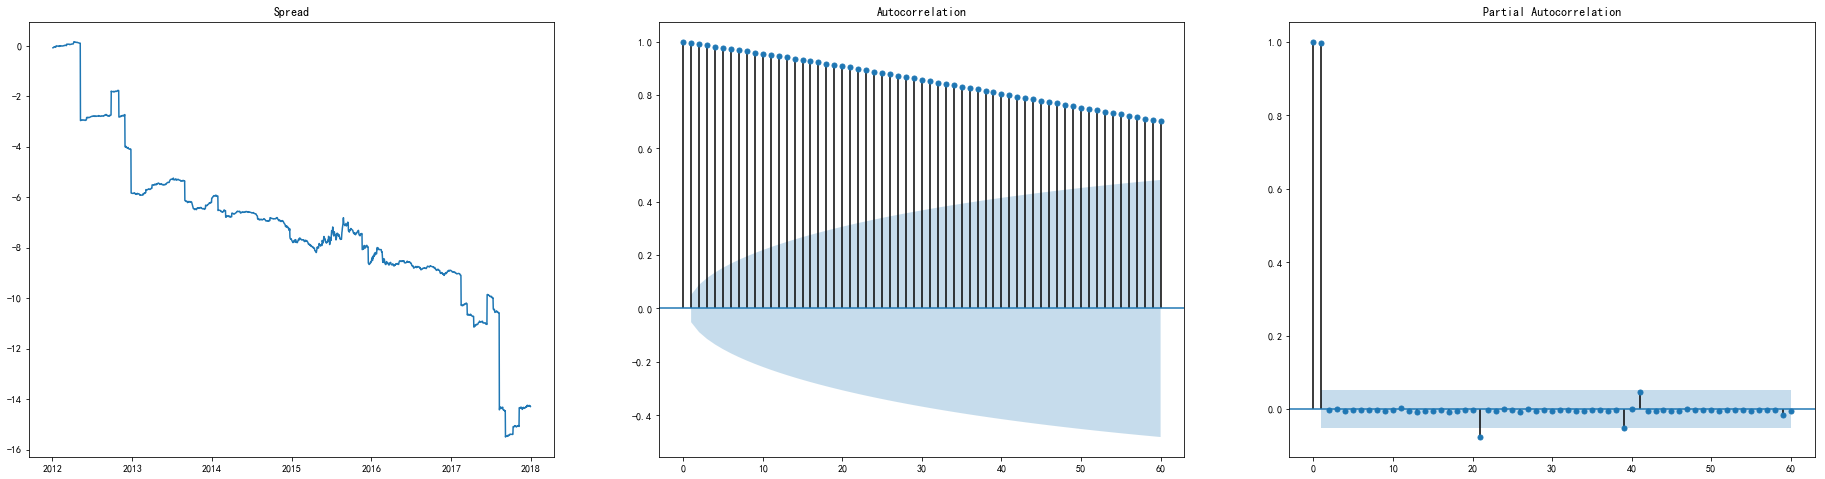

In [27]:
# 滚动训练计算对冲比例(TODO)
TestStartDT = dt.datetime(2012, 1, 1)# 测试集的起始时点
MovSampleLen = 480# 滚动样本长度
MinSampleLen = 240# 最小的样本长度
MovStep = 20# 一次滚动的期数
pValueThreshold = 0.1# p 值阈值

TestStartInd = np.sum((np.array(DTs)<TestStartDT))
HedgeRatio = pd.DataFrame(np.nan, index=StockPrice.index, columns=StockPrice.columns)
Avg = pd.Series(np.nan, index=StockPrice.index)
for i in tqdm_notebook(range(TestStartInd, len(DTs), MovStep)):
    iTrainStkPrice = StockPrice.iloc[max(0, i-MovSampleLen+1):i+1]
    iTrainETFPrice = ETFPrice.iloc[max(0, i-MovSampleLen+1):i+1]
    iMask = pd.notnull(iTrainETFPrice.values)
    iTargetStkIDs = []
    for j, jID in enumerate(tqdm_notebook(PCFCon.iloc[i][PCFCon.iloc[i]>0].index.tolist(), leave=False)):
        ijTrainStkPrice = iTrainStkPrice.loc[:, jID].values
        ijMask = (iMask & pd.notnull(ijTrainStkPrice))
        if np.sum(ijMask)<MinSampleLen: continue
        iCointEGTest = sm.tsa.stattools.coint(iTrainETFPrice.values[ijMask], ijTrainStkPrice[ijMask], trend="c", autolag="BIC")
        if iCointEGTest[1]<=pValueThreshold: iTargetStkIDs.append(jID)
    if not iTargetStkIDs: continue
    iStkPortLogVal = np.log(iTrainStkPrice.loc[:, iTargetStkIDs]).sum(axis=1)# 等权组合
    iCointEGTest = sm.tsa.stattools.coint(np.log(iTrainETFPrice.values), iStkPortLogVal.values, trend="c", autolag="BIC")
    if iCointEGTest[1]>pValueThreshold: continue
    iCointJohansenTest = sm.tsa.var.vecm.coint_johansen(np.c_[np.log(iTrainETFPrice.values), iStkPortLogVal.values], det_order=0, k_ar_diff=1)
    iHedgeRatio = CointJohansenTest.evec[1, 0] / CointJohansenTest.evec[0, 0]
    if iHedgeRatio >= 0: continue
    HedgeRatio.loc[DTs[i], iTargetStkIDs] = iHedgeRatio
    Avg.iloc[i] = np.nanmean(np.log(iTrainETFPrice.values) + iStkPortLogVal.values * iHedgeRatio)
HedgeRatio = HedgeRatio.fillna(method="pad")
Avg = Avg.fillna(method="pad")

Spread = pd.Series(np.nansum(np.c_[np.log(ETFPrice.values), np.log(StockPrice.values)*HedgeRatio.values], axis=1), index=StockPrice.index)
Spread = (Spread - Avg).iloc[TestStartInd:]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.

